# Обучение модели сегментации зданий

Семантическая сегментация для оценки площади зданий с использованием UNet с энкодером ResNet-50.

**Датасет**: Inria Aerial Image Labeling Dataset
- Разрешение: 0.3 м/пиксель
- Размер изображений: 5000×5000 пикселей
- Классы: Здание (1) / Фон (0)

## 1. Импорты и конфигурация

In [21]:
from __future__ import annotations

import json
import logging
import math
import random
import sys
import warnings
from pathlib import Path

# Добавляем корень проекта в путь для импортов
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.amp import GradScaler, autocast
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from src.datasets import (
    IMAGENET_MEAN,
    IMAGENET_STD,
    InriaSegmentationDataset,
    get_train_transforms,
    get_val_transforms,
)
from src.losses import BCEDiceLoss
from src.models import UNet
from src.utils import (
    calculate_area_m2,
    calculate_iou,
    calculate_pixel_metrics,
    load_checkpoint,
    plot_training_curves,
    save_checkpoint,
    seed_everything,
    visualize_segmentation,
)

# Подавление конкретных предупреждений от библиотек
warnings.filterwarnings("ignore", category=UserWarning, module="torch")
warnings.filterwarnings("ignore", category=FutureWarning, module="rasterio")

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

In [23]:
# ==================== CONFIGURATION ====================

# Paths
DATA_DIR = project_root / "data" / "raw"
CHECKPOINT_DIR = project_root / "checkpoints" / "segmentation"
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

# Training hyperparameters
SEED = 42
BATCH_SIZE = 16  # RTX 3090 24GB — можно увеличить до 24 при необходимости
NUM_WORKERS = 8  # Больше workers для быстрой загрузки данных
TILE_SIZE = 512
TILES_PER_IMAGE = 10  # Сколько тайлов семплировать с каждого изображения

# Optimizer
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4

# Training
NUM_EPOCHS = 30
GRADIENT_CLIP = 1.0

# Loss weights
BCE_WEIGHT = 0.5
DICE_WEIGHT = 0.5

# Dataset parameters
GSD = 0.3  # Ground Sampling Distance (meters/pixel) для Inria dataset

# Inference optimization (RTX 3090)
INFERENCE_BATCH_SIZE = 16  # Больше тайлов параллельно при inference

# Device and RTX 3090 (Ampere) optimizations
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    
    # TensorFloat-32: ускоряет float32 matmul/convolutions на Ampere без потери точности
    # ~2x ускорение для float32 операций
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    
    # cuDNN benchmark: находит оптимальные алгоритмы для convolutions
    # Безопасно включать при фиксированных размерах входов
    torch.backends.cudnn.benchmark = True
    
    print("TF32 enabled: matmul + cudnn")
    print("cuDNN benchmark: enabled")

Using device: cuda
GPU: NVIDIA GeForce RTX 3090
Memory: 25.4 GB
TF32 enabled: matmul + cudnn
cuDNN benchmark: enabled


## 2. Установка seed для воспроизводимости

In [3]:
seed_everything(SEED)
print(f"Random seed set to {SEED}")

Random seed set to 42


## 3. Загрузка датасета и создание DataLoader'ов

In [4]:
# Transforms
train_transforms = get_train_transforms(crop_size=TILE_SIZE)

# Валидация: CenterCrop + tiles_per_image=1 даёт детерминированную оценку,
# но использует только центр 512x512 из 5000x5000 изображения.
# Для более полной оценки используйте sliding window inference в конце.
VAL_TILES_PER_IMAGE = 1  # Увеличьте и установите use_random_crop=True для лучшего покрытия
VAL_USE_RANDOM_CROP = False  # True для случайного семплирования (менее детерминировано)

val_transforms = get_val_transforms(crop_size=TILE_SIZE, use_random_crop=VAL_USE_RANDOM_CROP)

# Datasets
train_dataset = InriaSegmentationDataset(
    data_dir=DATA_DIR,
    split="train",
    transform=train_transforms,
    tile_size=TILE_SIZE,
    tiles_per_image=TILES_PER_IMAGE,
)

val_dataset = InriaSegmentationDataset(
    data_dir=DATA_DIR,
    split="val",
    transform=val_transforms,
    tile_size=TILE_SIZE,
    tiles_per_image=VAL_TILES_PER_IMAGE,
)

print(f"Train dataset: {len(train_dataset)} samples ({train_dataset.num_images} images)")
print(f"Val dataset: {len(val_dataset)} samples ({val_dataset.num_images} images)")

2026-01-27 20:16:41,564 - INFO - Found 155 images for split 'train'
2026-01-27 20:16:41,565 - INFO - Found 25 images for split 'val'


Train dataset: 1550 samples (155 images)
Val dataset: 25 samples (25 images)


In [5]:
def worker_init_fn(worker_id: int) -> None:
    """Initialize worker with deterministic seed."""
    worker_seed = SEED + worker_id
    random.seed(worker_seed)
    np.random.seed(worker_seed)
    torch.manual_seed(worker_seed)


# Проверка наличия данных перед созданием loaders
if len(train_dataset) == 0:
    raise ValueError("Train dataset is empty! Check DATA_DIR path and data availability.")
if len(val_dataset) == 0:
    raise ValueError("Validation dataset is empty! Check DATA_DIR path and data availability.")

# DataLoaders с оптимизацией для RTX 3090
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=True,
    worker_init_fn=worker_init_fn,
    persistent_workers=NUM_WORKERS > 0,  # Ускоряет повторные эпохи
    prefetch_factor=4,  # Предзагрузка батчей — GPU не простаивает
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    worker_init_fn=worker_init_fn,
    persistent_workers=NUM_WORKERS > 0,
    prefetch_factor=4,
)

print(f"Train batches per epoch: {len(train_loader)}")
print(f"Val batches per epoch: {len(val_loader)}")

Train batches per epoch: 96
Val batches per epoch: 2


## 4. Инициализация модели

In [6]:
model = UNet(num_classes=1, pretrained_encoder=True)
model = model.to(DEVICE)

# Подсчёт параметров
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# torch.compile() для RTX 3090 — даёт ~15-30% ускорение на PyTorch 2.x
# Используем mode="reduce-overhead" для лучшего баланса compile time vs speedup
USE_TORCH_COMPILE = DEVICE.type == "cuda" and hasattr(torch, "compile")
MODEL_IS_COMPILED = False

if USE_TORCH_COMPILE:
    print("Compiling model with torch.compile()...")
    try:
        model = torch.compile(model, mode="reduce-overhead")
        MODEL_IS_COMPILED = True
        print("Model compiled successfully")
    except Exception as e:
        # Fallback: продолжаем без компиляции если torch.compile() недоступен
        logger.warning(f"torch.compile() failed, continuing without compilation: {e}")
        print(f"[!] torch.compile() failed: {e}")
        print("    Continuing without compilation...")

Total parameters: 47,454,529
Trainable parameters: 47,454,529
Compiling model with torch.compile()...
Model compiled successfully


## 5. Определение функции потерь

In [7]:
criterion = BCEDiceLoss(
    bce_weight=BCE_WEIGHT,
    dice_weight=DICE_WEIGHT,
)

print(f"Loss: BCE ({BCE_WEIGHT}) + Dice ({DICE_WEIGHT})")

Loss: BCE (0.5) + Dice (0.5)


## 6. Инициализация оптимизатора и планировщика

In [8]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
)

# OneCycleLR scheduler для лучшей сходимости
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=LEARNING_RATE * 10,
    epochs=NUM_EPOCHS,
    steps_per_epoch=len(train_loader),
    pct_start=0.1,  # 10% warmup
    anneal_strategy="cos",
)

# GradScaler для mixed precision (только на GPU)
# Совместимость с разными версиями PyTorch (2.3 и ниже не поддерживают device=)
USE_AMP = DEVICE.type == "cuda"
if USE_AMP:
    try:
        # PyTorch 2.4+: поддерживает device kwarg
        scaler = GradScaler(device="cuda")
    except TypeError:
        # PyTorch < 2.4: без device kwarg
        scaler = GradScaler()
else:
    scaler = None

print(f"Optimizer: AdamW (lr={LEARNING_RATE}, weight_decay={WEIGHT_DECAY})")
print(f"Scheduler: OneCycleLR (max_lr={LEARNING_RATE * 10})")
print(f"Mixed Precision: {USE_AMP}")

Optimizer: AdamW (lr=0.0001, weight_decay=0.0001)
Scheduler: OneCycleLR (max_lr=0.001)
Mixed Precision: True


## 7. Цикл обучения

In [9]:
def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler.LRScheduler,
    scaler: GradScaler | None,
    device: torch.device,
    epoch: int,
    num_epochs: int,
    use_amp: bool = True,
    gradient_clip: float = 1.0,
) -> tuple[float, float]:
    """
    Train for one epoch.
    
    Args:
        model: Model to train.
        loader: Training data loader.
        criterion: Loss function.
        optimizer: Optimizer.
        scheduler: Learning rate scheduler.
        scaler: GradScaler for mixed precision (None if not using AMP).
        device: Device to train on.
        epoch: Current epoch number.
        num_epochs: Total number of epochs.
        use_amp: Whether to use automatic mixed precision.
        gradient_clip: Max gradient norm for clipping.
    
    Returns:
        Tuple of (average_loss, average_iou)
    """
    model.train()
    total_loss = 0.0
    total_iou = 0.0
    num_batches = 0
    
    pbar = tqdm(
        loader,
        desc=f"  Train [{epoch:02d}/{num_epochs:02d}]",
        bar_format="{desc} |{bar:25}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}] {postfix}",
        leave=True,
    )
    
    for batch_idx, batch in enumerate(pbar):
        # non_blocking=True: асинхронная передача на GPU (работает с pin_memory)
        images = batch["image"].to(device, non_blocking=True)
        masks = batch["mask"].to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)  # Быстрее чем zero_grad()
        
        # Forward pass with optional mixed precision
        with autocast(device_type=device.type, dtype=torch.float16, enabled=use_amp):
            outputs = model(images)
            loss = criterion(outputs, masks)
        
        # Check for NaN/Inf — пропускаем backward, но scheduler.step() вызываем всегда
        # чтобы не сбивать расписание OneCycleLR
        if torch.isnan(loss) or torch.isinf(loss):
            tqdm.write(f"  [!] NaN/Inf loss at batch {batch_idx}, skipping backward...")
            scheduler.step()  # Сохраняем расписание lr
            continue
        
        # Backward pass
        if use_amp and scaler is not None:
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
            optimizer.step()
        
        # Scheduler step (OneCycleLR steps per batch)
        scheduler.step()
        
        # Calculate IoU for logging
        # outputs: (B, 1, H, W), masks: (B, H, W) — приводим к одинаковой размерности
        with torch.no_grad():
            pred_masks = (torch.sigmoid(outputs) > 0.5).squeeze(1)  # (B, H, W)
            iou = calculate_iou(pred_masks, masks)
        
        total_loss += loss.item()
        total_iou += iou
        num_batches += 1
        
        # Update progress bar
        pbar.set_postfix_str(
            f"loss={loss.item():.4f} | iou={iou*100:.1f}% | lr={scheduler.get_last_lr()[0]:.1e}"
        )
    
    # Защита от деления на ноль
    if num_batches == 0:
        logger.warning("No valid batches in epoch!")
        return float("inf"), 0.0
    
    return total_loss / num_batches, total_iou / num_batches

## 8. Цикл валидации

In [10]:
@torch.inference_mode()
def validate(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    device: torch.device,
    use_amp: bool = True,
) -> tuple[float, dict]:
    """
    Validate model on validation set.
    
    Returns:
        Tuple of (average_loss, metrics_dict)
    """
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_targets = []
    
    pbar = tqdm(
        loader,
        desc="  Valid",
        bar_format="{desc}          |{bar:25}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]",
        leave=True,
    )
    
    for batch in pbar:
        images = batch["image"].to(device, non_blocking=True)
        masks = batch["mask"].to(device, non_blocking=True)
        
        # Mixed precision на inference тоже ускоряет
        with autocast(device_type=device.type, dtype=torch.float16, enabled=use_amp):
            outputs = model(images)
            loss = criterion(outputs, masks)
        
        total_loss += loss.item()
        
        # Collect predictions for metrics
        # outputs: (B, 1, H, W), masks: (B, H, W)
        # Приводим к одинаковой размерности (B, H, W) для корректного concat
        pred_masks = torch.sigmoid(outputs.float()).squeeze(1)  # (B, H, W)
        all_preds.append(pred_masks.cpu())
        all_targets.append(masks.float().cpu())
    
    # Защита от пустого loader
    if len(all_preds) == 0:
        logger.warning("No valid batches in validation!")
        return float("inf"), {
            "iou": 0.0,
            "accuracy": 0.0,
            "precision": 0.0,
            "recall": 0.0,
            "f1": 0.0,
        }
    
    # Calculate metrics on all predictions
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    
    metrics = calculate_pixel_metrics(all_preds, all_targets)
    
    num_batches = len(loader)
    avg_loss = total_loss / num_batches if num_batches > 0 else float("inf")
    
    return avg_loss, {
        "iou": metrics.iou,
        "accuracy": metrics.accuracy,
        "precision": metrics.precision,
        "recall": metrics.recall,
        "f1": metrics.f1,
    }

## 9. Обучение

In [11]:
# Training history
history = {
    "train_loss": [],
    "train_iou": [],
    "val_loss": [],
    "val_iou": [],
    "val_f1": [],
    "lr": [],
}

best_iou = 0.0
best_epoch = 0
patience_counter = 0
start_epoch = 1
EARLY_STOPPING_PATIENCE = 7  # Останавливаем если нет улучшения N эпох

# Resume training: загрузка существующего чекпоинта
RESUME_TRAINING = False  # Установить True для продолжения обучения
resume_checkpoint_path = CHECKPOINT_DIR / "seg_final_model.pth"

if RESUME_TRAINING and resume_checkpoint_path.exists():
    print(f"Resuming training from {resume_checkpoint_path}")
    
    # ВАЖНО: OneCycleLR имеет фиксированное число шагов при создании.
    # При resume scheduler state восстанавливается, но если обучение было прервано
    # не в конце эпохи, scheduler может быть в неконсистентном состоянии.
    # Рекомендуется использовать CosineAnnealingLR для resume или начинать с начала.
    logger.warning(
        "Resuming with OneCycleLR scheduler. If training was interrupted mid-epoch, "
        "scheduler state may be inconsistent. Consider using CosineAnnealingLR for resume."
    )
    
    state = load_checkpoint(
        resume_checkpoint_path,
        model,
        optimizer=optimizer,
        scheduler=scheduler,
        scaler=scaler,
        device=DEVICE,
    )
    start_epoch = state.get("epoch", 0) + 1
    best_iou = state.get("best_metric", 0.0)
    print(f"Resumed from epoch {start_epoch - 1}, best IoU: {best_iou:.4f}")
    
    # Загружаем историю если есть
    history_path = CHECKPOINT_DIR / "seg_training_history.json"
    if history_path.exists():
        with open(history_path) as f:
            history = json.load(f)
        print(f"Loaded training history ({len(history['train_loss'])} epochs)")

print("=" * 60)
print(f"  Starting training: epochs {start_epoch} to {NUM_EPOCHS}")
print(f"  Batches: {len(train_loader)} train | {len(val_loader)} val")
print(f"  Early stopping patience: {EARLY_STOPPING_PATIENCE}")
print("=" * 60)

  Starting training: epochs 1 to 30
  Batches: 96 train | 2 val
  Early stopping patience: 7


In [12]:
def print_epoch_summary(epoch: int, num_epochs: int, train_loss: float, train_iou: float, 
                        val_loss: float, val_metrics: dict, is_best: bool = False,
                        patience: int = 0, max_patience: int = 7) -> None:
    """Prints a nicely formatted epoch summary."""
    iou_pct = val_metrics["iou"] * 100
    acc_pct = val_metrics["accuracy"] * 100
    f1_pct = val_metrics["f1"] * 100
    prec_pct = val_metrics["precision"] * 100
    rec_pct = val_metrics["recall"] * 100
    
    best_marker = " * BEST" if is_best else f" (patience {patience}/{max_patience})"
    
    print(f"\n  +{'-'*56}+")
    print(f"  |  Epoch {epoch:02d}/{num_epochs:02d} Summary{best_marker:>35} |")
    print(f"  +{'-'*56}+")
    print(f"  |  {'Train':<8} | Loss: {train_loss:.4f}  |  IoU: {train_iou*100:5.1f}%{' '*14}|")
    print(f"  |  {'Valid':<8} | Loss: {val_loss:.4f}  |  IoU: {iou_pct:5.1f}%{' '*14}|")
    print(f"  +{'-'*56}+")
    print(f"  |  Acc: {acc_pct:5.1f}%  |  P: {prec_pct:5.1f}%  |  R: {rec_pct:5.1f}%  |  F1: {f1_pct:5.1f}%   |")
    print(f"  +{'-'*56}+")


# Для отслеживания финальной эпохи (после early stopping или resume)
# Инициализируем как start_epoch - 1 для корректной работы при resume
final_epoch = max(start_epoch - 1, 0)

for epoch in range(start_epoch, NUM_EPOCHS + 1):
    final_epoch = epoch
    
    # Train
    train_loss, train_iou = train_one_epoch(
        model=model,
        loader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        scaler=scaler,
        device=DEVICE,
        epoch=epoch,
        num_epochs=NUM_EPOCHS,
        use_amp=USE_AMP,
        gradient_clip=GRADIENT_CLIP,
    )
    
    # Validate
    val_loss, val_metrics = validate(
        model=model,
        loader=val_loader,
        criterion=criterion,
        device=DEVICE,
        use_amp=USE_AMP,
    )
    
    # Save history
    history["train_loss"].append(train_loss)
    history["train_iou"].append(train_iou)
    history["val_loss"].append(val_loss)
    history["val_iou"].append(val_metrics["iou"])
    history["val_f1"].append(val_metrics["f1"])
    history["lr"].append(scheduler.get_last_lr()[0])
    
    # Check for best model
    is_best = val_metrics["iou"] > best_iou
    if is_best:
        best_iou = val_metrics["iou"]
        best_epoch = epoch
        patience_counter = 0
        
        save_checkpoint(
            model=model,
            optimizer=optimizer,
            scheduler=scheduler,
            epoch=epoch,
            global_step=epoch * len(train_loader),
            best_metric=best_iou,
            path=CHECKPOINT_DIR / "seg_best_model.pth",
            scaler=scaler,
            metrics=val_metrics,
        )
    else:
        patience_counter += 1
    
    # Print summary
    print_epoch_summary(
        epoch, NUM_EPOCHS, train_loss, train_iou, val_loss, val_metrics, 
        is_best, patience_counter, EARLY_STOPPING_PATIENCE
    )
    
    # Early stopping
    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"\n[!] Early stopping triggered at epoch {epoch}")
        break
    
    # Очистка CUDA кеша между эпохами для предотвращения OOM
    if DEVICE.type == "cuda":
        torch.cuda.empty_cache()

# Save training history
history_path = CHECKPOINT_DIR / "seg_training_history.json"
with open(history_path, "w") as f:
    json.dump(history, f, indent=2)
print(f"\nTraining history saved to {history_path}")

print("\n" + "=" * 60)
print(f"  Training completed! Best IoU: {best_iou*100:.1f}% at epoch {best_epoch}")
print("=" * 60)

  Train [01/30] |█████████████████████████| 96/96 [02:11<00:00,  1.37s/it] , loss=0.4843 | iou=60.0% | lr=2.8e-04 
  Valid          |█████████████████████████| 2/2 [00:15<00:00,  7.64s/it]
2026-01-27 20:19:13,113 - INFO - Checkpoint saved to /home/user/code/dls_project/checkpoints/segmentation/seg_best_model.pth



  +--------------------------------------------------------+
  |  Epoch 01/30 Summary                             * BEST |
  +--------------------------------------------------------+
  |  Train    | Loss: 0.6311  |  IoU:  44.3%              |
  |  Valid    | Loss: 0.4238  |  IoU:  68.8%              |
  +--------------------------------------------------------+
  |  Acc:  94.4%  |  P:  78.1%  |  R:  85.3%  |  F1:  81.5%   |
  +--------------------------------------------------------+


  Train [02/30] |█████████████████████████| 96/96 [02:10<00:00,  1.36s/it] , loss=0.3688 | iou=60.3% | lr=7.6e-04 
  Valid          |█████████████████████████| 2/2 [00:08<00:00,  4.36s/it]



  +--------------------------------------------------------+
  |  Epoch 02/30 Summary                     (patience 1/7) |
  +--------------------------------------------------------+
  |  Train    | Loss: 0.3597  |  IoU:  63.4%              |
  |  Valid    | Loss: 0.3891  |  IoU:  57.2%              |
  +--------------------------------------------------------+
  |  Acc:  92.8%  |  P:  79.7%  |  R:  67.0%  |  F1:  72.8%   |
  +--------------------------------------------------------+


  Train [03/30] |█████████████████████████| 96/96 [02:10<00:00,  1.36s/it] , loss=0.3171 | iou=58.1% | lr=1.0e-03 
  Valid          |█████████████████████████| 2/2 [00:08<00:00,  4.31s/it]



  +--------------------------------------------------------+
  |  Epoch 03/30 Summary                     (patience 2/7) |
  +--------------------------------------------------------+
  |  Train    | Loss: 0.3244  |  IoU:  63.1%              |
  |  Valid    | Loss: 0.3349  |  IoU:  63.2%              |
  +--------------------------------------------------------+
  |  Acc:  93.1%  |  P:  73.0%  |  R:  82.4%  |  F1:  77.4%   |
  +--------------------------------------------------------+


  Train [04/30] |█████████████████████████| 96/96 [02:10<00:00,  1.36s/it] , loss=0.3924 | iou=58.0% | lr=1.0e-03 
  Valid          |█████████████████████████| 2/2 [00:08<00:00,  4.21s/it]



  +--------------------------------------------------------+
  |  Epoch 04/30 Summary                     (patience 3/7) |
  +--------------------------------------------------------+
  |  Train    | Loss: 0.3127  |  IoU:  64.7%              |
  |  Valid    | Loss: 0.3636  |  IoU:  62.1%              |
  +--------------------------------------------------------+
  |  Acc:  93.5%  |  P:  78.5%  |  R:  74.9%  |  F1:  76.6%   |
  +--------------------------------------------------------+


  Train [05/30] |█████████████████████████| 96/96 [02:09<00:00,  1.35s/it] , loss=0.2237 | iou=69.3% | lr=9.9e-04 
  Valid          |█████████████████████████| 2/2 [00:08<00:00,  4.30s/it]
2026-01-27 20:28:37,476 - INFO - Checkpoint saved to /home/user/code/dls_project/checkpoints/segmentation/seg_best_model.pth



  +--------------------------------------------------------+
  |  Epoch 05/30 Summary                             * BEST |
  +--------------------------------------------------------+
  |  Train    | Loss: 0.2948  |  IoU:  67.1%              |
  |  Valid    | Loss: 0.2725  |  IoU:  73.2%              |
  +--------------------------------------------------------+
  |  Acc:  95.4%  |  P:  82.2%  |  R:  87.0%  |  F1:  84.5%   |
  +--------------------------------------------------------+


  Train [06/30] |█████████████████████████| 96/96 [02:10<00:00,  1.36s/it] , loss=0.3554 | iou=63.3% | lr=9.7e-04 
  Valid          |█████████████████████████| 2/2 [00:08<00:00,  4.28s/it]



  +--------------------------------------------------------+
  |  Epoch 06/30 Summary                     (patience 1/7) |
  +--------------------------------------------------------+
  |  Train    | Loss: 0.2934  |  IoU:  67.4%              |
  |  Valid    | Loss: 0.2903  |  IoU:  70.3%              |
  +--------------------------------------------------------+
  |  Acc:  95.0%  |  P:  83.2%  |  R:  81.9%  |  F1:  82.5%   |
  +--------------------------------------------------------+


  Train [07/30] |█████████████████████████| 96/96 [02:10<00:00,  1.36s/it] , loss=0.2569 | iou=76.5% | lr=9.5e-04 
  Valid          |█████████████████████████| 2/2 [00:08<00:00,  4.30s/it]
2026-01-27 20:33:21,132 - INFO - Checkpoint saved to /home/user/code/dls_project/checkpoints/segmentation/seg_best_model.pth



  +--------------------------------------------------------+
  |  Epoch 07/30 Summary                             * BEST |
  +--------------------------------------------------------+
  |  Train    | Loss: 0.2854  |  IoU:  68.6%              |
  |  Valid    | Loss: 0.2704  |  IoU:  73.7%              |
  +--------------------------------------------------------+
  |  Acc:  95.6%  |  P:  84.1%  |  R:  85.7%  |  F1:  84.9%   |
  +--------------------------------------------------------+


  Train [08/30] |█████████████████████████| 96/96 [02:10<00:00,  1.36s/it] , loss=0.2330 | iou=72.2% | lr=9.2e-04 
  Valid          |█████████████████████████| 2/2 [00:08<00:00,  4.20s/it]



  +--------------------------------------------------------+
  |  Epoch 08/30 Summary                     (patience 1/7) |
  +--------------------------------------------------------+
  |  Train    | Loss: 0.2744  |  IoU:  69.3%              |
  |  Valid    | Loss: 0.3041  |  IoU:  68.4%              |
  +--------------------------------------------------------+
  |  Acc:  95.1%  |  P:  89.1%  |  R:  74.7%  |  F1:  81.3%   |
  +--------------------------------------------------------+


  Train [09/30] |█████████████████████████| 96/96 [02:09<00:00,  1.35s/it] , loss=0.2918 | iou=67.8% | lr=8.8e-04 
  Valid          |█████████████████████████| 2/2 [00:08<00:00,  4.23s/it]



  +--------------------------------------------------------+
  |  Epoch 09/30 Summary                     (patience 2/7) |
  +--------------------------------------------------------+
  |  Train    | Loss: 0.2804  |  IoU:  70.4%              |
  |  Valid    | Loss: 0.2797  |  IoU:  72.5%              |
  +--------------------------------------------------------+
  |  Acc:  95.2%  |  P:  80.2%  |  R:  88.3%  |  F1:  84.0%   |
  +--------------------------------------------------------+


  Train [10/30] |█████████████████████████| 96/96 [02:10<00:00,  1.36s/it] , loss=0.2757 | iou=67.3% | lr=8.4e-04 
  Valid          |█████████████████████████| 2/2 [00:08<00:00,  4.26s/it]



  +--------------------------------------------------------+
  |  Epoch 10/30 Summary                     (patience 3/7) |
  +--------------------------------------------------------+
  |  Train    | Loss: 0.2655  |  IoU:  71.5%              |
  |  Valid    | Loss: 0.2788  |  IoU:  72.9%              |
  +--------------------------------------------------------+
  |  Acc:  95.3%  |  P:  80.2%  |  R:  89.0%  |  F1:  84.3%   |
  +--------------------------------------------------------+


  Train [11/30] |█████████████████████████| 96/96 [02:10<00:00,  1.36s/it] , loss=0.2947 | iou=75.1% | lr=8.0e-04 
  Valid          |█████████████████████████| 2/2 [00:08<00:00,  4.29s/it]
2026-01-27 20:42:44,708 - INFO - Checkpoint saved to /home/user/code/dls_project/checkpoints/segmentation/seg_best_model.pth



  +--------------------------------------------------------+
  |  Epoch 11/30 Summary                             * BEST |
  +--------------------------------------------------------+
  |  Train    | Loss: 0.2610  |  IoU:  72.0%              |
  |  Valid    | Loss: 0.2651  |  IoU:  75.0%              |
  +--------------------------------------------------------+
  |  Acc:  95.9%  |  P:  85.9%  |  R:  85.5%  |  F1:  85.7%   |
  +--------------------------------------------------------+


  Train [12/30] |█████████████████████████| 96/96 [02:10<00:00,  1.36s/it] , loss=0.2690 | iou=76.1% | lr=7.5e-04 
  Valid          |█████████████████████████| 2/2 [00:08<00:00,  4.37s/it]



  +--------------------------------------------------------+
  |  Epoch 12/30 Summary                     (patience 1/7) |
  +--------------------------------------------------------+
  |  Train    | Loss: 0.2610  |  IoU:  72.0%              |
  |  Valid    | Loss: 0.2687  |  IoU:  74.0%              |
  +--------------------------------------------------------+
  |  Acc:  95.6%  |  P:  82.8%  |  R:  87.3%  |  F1:  85.0%   |
  +--------------------------------------------------------+


  Train [13/30] |█████████████████████████| 96/96 [02:11<00:00,  1.37s/it] , loss=0.1740 | iou=81.5% | lr=7.0e-04 
  Valid          |█████████████████████████| 2/2 [00:08<00:00,  4.38s/it]



  +--------------------------------------------------------+
  |  Epoch 13/30 Summary                     (patience 2/7) |
  +--------------------------------------------------------+
  |  Train    | Loss: 0.2723  |  IoU:  71.1%              |
  |  Valid    | Loss: 0.2737  |  IoU:  73.7%              |
  +--------------------------------------------------------+
  |  Acc:  95.4%  |  P:  81.2%  |  R:  88.8%  |  F1:  84.8%   |
  +--------------------------------------------------------+


  Train [14/30] |█████████████████████████| 96/96 [02:11<00:00,  1.37s/it] , loss=0.2424 | iou=75.0% | lr=6.4e-04 
  Valid          |█████████████████████████| 2/2 [00:08<00:00,  4.25s/it]
2026-01-27 20:49:50,927 - INFO - Checkpoint saved to /home/user/code/dls_project/checkpoints/segmentation/seg_best_model.pth



  +--------------------------------------------------------+
  |  Epoch 14/30 Summary                             * BEST |
  +--------------------------------------------------------+
  |  Train    | Loss: 0.2525  |  IoU:  73.6%              |
  |  Valid    | Loss: 0.2650  |  IoU:  75.5%              |
  +--------------------------------------------------------+
  |  Acc:  96.0%  |  P:  85.8%  |  R:  86.3%  |  F1:  86.1%   |
  +--------------------------------------------------------+


  Train [15/30] |█████████████████████████| 96/96 [02:11<00:00,  1.36s/it] , loss=0.2053 | iou=76.7% | lr=5.9e-04 
  Valid          |█████████████████████████| 2/2 [00:08<00:00,  4.23s/it]



  +--------------------------------------------------------+
  |  Epoch 15/30 Summary                     (patience 1/7) |
  +--------------------------------------------------------+
  |  Train    | Loss: 0.2523  |  IoU:  74.4%              |
  |  Valid    | Loss: 0.2606  |  IoU:  75.3%              |
  +--------------------------------------------------------+
  |  Acc:  96.0%  |  P:  86.7%  |  R:  85.1%  |  F1:  85.9%   |
  +--------------------------------------------------------+


  Train [16/30] |█████████████████████████| 96/96 [02:10<00:00,  1.36s/it] , loss=0.2519 | iou=75.8% | lr=5.3e-04 
  Valid          |█████████████████████████| 2/2 [00:08<00:00,  4.25s/it]
2026-01-27 20:54:34,159 - INFO - Checkpoint saved to /home/user/code/dls_project/checkpoints/segmentation/seg_best_model.pth



  +--------------------------------------------------------+
  |  Epoch 16/30 Summary                             * BEST |
  +--------------------------------------------------------+
  |  Train    | Loss: 0.2430  |  IoU:  75.0%              |
  |  Valid    | Loss: 0.2590  |  IoU:  75.9%              |
  +--------------------------------------------------------+
  |  Acc:  96.1%  |  P:  87.9%  |  R:  84.7%  |  F1:  86.3%   |
  +--------------------------------------------------------+


  Train [17/30] |█████████████████████████| 96/96 [02:10<00:00,  1.36s/it] , loss=0.1978 | iou=74.5% | lr=4.7e-04 
  Valid          |█████████████████████████| 2/2 [00:08<00:00,  4.17s/it]



  +--------------------------------------------------------+
  |  Epoch 17/30 Summary                     (patience 1/7) |
  +--------------------------------------------------------+
  |  Train    | Loss: 0.2388  |  IoU:  74.9%              |
  |  Valid    | Loss: 0.2573  |  IoU:  75.0%              |
  +--------------------------------------------------------+
  |  Acc:  96.0%  |  P:  87.5%  |  R:  84.0%  |  F1:  85.7%   |
  +--------------------------------------------------------+


  Train [18/30] |█████████████████████████| 96/96 [02:10<00:00,  1.36s/it] , loss=0.1414 | iou=79.8% | lr=4.1e-04 
  Valid          |█████████████████████████| 2/2 [00:08<00:00,  4.24s/it]



  +--------------------------------------------------------+
  |  Epoch 18/30 Summary                     (patience 2/7) |
  +--------------------------------------------------------+
  |  Train    | Loss: 0.2437  |  IoU:  75.3%              |
  |  Valid    | Loss: 0.2584  |  IoU:  75.7%              |
  +--------------------------------------------------------+
  |  Acc:  96.1%  |  P:  87.9%  |  R:  84.6%  |  F1:  86.2%   |
  +--------------------------------------------------------+


  Train [19/30] |█████████████████████████| 96/96 [02:11<00:00,  1.36s/it] , loss=0.2676 | iou=79.2% | lr=3.6e-04 
  Valid          |█████████████████████████| 2/2 [00:08<00:00,  4.32s/it]
2026-01-27 21:01:37,752 - INFO - Checkpoint saved to /home/user/code/dls_project/checkpoints/segmentation/seg_best_model.pth



  +--------------------------------------------------------+
  |  Epoch 19/30 Summary                             * BEST |
  +--------------------------------------------------------+
  |  Train    | Loss: 0.2434  |  IoU:  75.1%              |
  |  Valid    | Loss: 0.2558  |  IoU:  76.2%              |
  +--------------------------------------------------------+
  |  Acc:  96.1%  |  P:  86.2%  |  R:  86.8%  |  F1:  86.5%   |
  +--------------------------------------------------------+


  Train [20/30] |█████████████████████████| 96/96 [02:11<00:00,  1.37s/it] , loss=0.2111 | iou=80.5% | lr=3.0e-04 
  Valid          |█████████████████████████| 2/2 [00:08<00:00,  4.34s/it]
2026-01-27 21:04:00,089 - INFO - Checkpoint saved to /home/user/code/dls_project/checkpoints/segmentation/seg_best_model.pth



  +--------------------------------------------------------+
  |  Epoch 20/30 Summary                             * BEST |
  +--------------------------------------------------------+
  |  Train    | Loss: 0.2253  |  IoU:  76.5%              |
  |  Valid    | Loss: 0.2586  |  IoU:  76.2%              |
  +--------------------------------------------------------+
  |  Acc:  96.1%  |  P:  86.8%  |  R:  86.2%  |  F1:  86.5%   |
  +--------------------------------------------------------+


  Train [21/30] |█████████████████████████| 96/96 [02:10<00:00,  1.35s/it] , loss=0.2459 | iou=79.5% | lr=2.5e-04 
  Valid          |█████████████████████████| 2/2 [00:08<00:00,  4.22s/it]
2026-01-27 21:06:21,192 - INFO - Checkpoint saved to /home/user/code/dls_project/checkpoints/segmentation/seg_best_model.pth



  +--------------------------------------------------------+
  |  Epoch 21/30 Summary                             * BEST |
  +--------------------------------------------------------+
  |  Train    | Loss: 0.2317  |  IoU:  76.3%              |
  |  Valid    | Loss: 0.2569  |  IoU:  77.0%              |
  +--------------------------------------------------------+
  |  Acc:  96.3%  |  P:  86.8%  |  R:  87.2%  |  F1:  87.0%   |
  +--------------------------------------------------------+


  Train [22/30] |█████████████████████████| 96/96 [02:10<00:00,  1.36s/it] , loss=0.2402 | iou=78.6% | lr=2.0e-04 
  Valid          |█████████████████████████| 2/2 [00:08<00:00,  4.20s/it]



  +--------------------------------------------------------+
  |  Epoch 22/30 Summary                     (patience 1/7) |
  +--------------------------------------------------------+
  |  Train    | Loss: 0.2259  |  IoU:  77.3%              |
  |  Valid    | Loss: 0.2562  |  IoU:  76.9%              |
  +--------------------------------------------------------+
  |  Acc:  96.3%  |  P:  87.0%  |  R:  86.8%  |  F1:  86.9%   |
  +--------------------------------------------------------+


  Train [23/30] |█████████████████████████| 96/96 [02:10<00:00,  1.36s/it] , loss=0.2663 | iou=73.5% | lr=1.6e-04 
  Valid          |█████████████████████████| 2/2 [00:08<00:00,  4.21s/it]



  +--------------------------------------------------------+
  |  Epoch 23/30 Summary                     (patience 2/7) |
  +--------------------------------------------------------+
  |  Train    | Loss: 0.2293  |  IoU:  76.4%              |
  |  Valid    | Loss: 0.2562  |  IoU:  76.9%              |
  +--------------------------------------------------------+
  |  Acc:  96.3%  |  P:  87.1%  |  R:  86.8%  |  F1:  87.0%   |
  +--------------------------------------------------------+


  Train [24/30] |█████████████████████████| 96/96 [02:11<00:00,  1.37s/it] , loss=0.2403 | iou=75.4% | lr=1.2e-04 
  Valid          |█████████████████████████| 2/2 [00:08<00:00,  4.16s/it]



  +--------------------------------------------------------+
  |  Epoch 24/30 Summary                     (patience 3/7) |
  +--------------------------------------------------------+
  |  Train    | Loss: 0.2372  |  IoU:  76.0%              |
  |  Valid    | Loss: 0.2548  |  IoU:  76.8%              |
  +--------------------------------------------------------+
  |  Acc:  96.2%  |  P:  86.9%  |  R:  86.8%  |  F1:  86.8%   |
  +--------------------------------------------------------+


  Train [25/30] |█████████████████████████| 96/96 [02:10<00:00,  1.36s/it] , loss=0.2572 | iou=76.5% | lr=8.2e-05 
  Valid          |█████████████████████████| 2/2 [00:08<00:00,  4.27s/it]
2026-01-27 21:15:46,268 - INFO - Checkpoint saved to /home/user/code/dls_project/checkpoints/segmentation/seg_best_model.pth



  +--------------------------------------------------------+
  |  Epoch 25/30 Summary                             * BEST |
  +--------------------------------------------------------+
  |  Train    | Loss: 0.2279  |  IoU:  76.7%              |
  |  Valid    | Loss: 0.2528  |  IoU:  77.0%              |
  +--------------------------------------------------------+
  |  Acc:  96.3%  |  P:  87.5%  |  R:  86.6%  |  F1:  87.0%   |
  +--------------------------------------------------------+


  Train [26/30] |█████████████████████████| 96/96 [02:11<00:00,  1.36s/it] , loss=0.1618 | iou=83.0% | lr=5.3e-05 
  Valid          |█████████████████████████| 2/2 [00:08<00:00,  4.27s/it]
2026-01-27 21:18:08,451 - INFO - Checkpoint saved to /home/user/code/dls_project/checkpoints/segmentation/seg_best_model.pth



  +--------------------------------------------------------+
  |  Epoch 26/30 Summary                             * BEST |
  +--------------------------------------------------------+
  |  Train    | Loss: 0.2222  |  IoU:  77.8%              |
  |  Valid    | Loss: 0.2548  |  IoU:  77.3%              |
  +--------------------------------------------------------+
  |  Acc:  96.3%  |  P:  87.3%  |  R:  87.1%  |  F1:  87.2%   |
  +--------------------------------------------------------+


  Train [27/30] |█████████████████████████| 96/96 [02:10<00:00,  1.36s/it] , loss=0.2285 | iou=71.1% | lr=3.0e-05 
  Valid          |█████████████████████████| 2/2 [00:08<00:00,  4.23s/it]
2026-01-27 21:20:30,597 - INFO - Checkpoint saved to /home/user/code/dls_project/checkpoints/segmentation/seg_best_model.pth



  +--------------------------------------------------------+
  |  Epoch 27/30 Summary                             * BEST |
  +--------------------------------------------------------+
  |  Train    | Loss: 0.2276  |  IoU:  76.7%              |
  |  Valid    | Loss: 0.2537  |  IoU:  77.4%              |
  +--------------------------------------------------------+
  |  Acc:  96.3%  |  P:  87.2%  |  R:  87.3%  |  F1:  87.3%   |
  +--------------------------------------------------------+


  Train [28/30] |█████████████████████████| 96/96 [02:10<00:00,  1.36s/it] , loss=0.2766 | iou=78.2% | lr=1.3e-05 
  Valid          |█████████████████████████| 2/2 [00:08<00:00,  4.25s/it]



  +--------------------------------------------------------+
  |  Epoch 28/30 Summary                     (patience 1/7) |
  +--------------------------------------------------------+
  |  Train    | Loss: 0.2159  |  IoU:  77.7%              |
  |  Valid    | Loss: 0.2543  |  IoU:  77.3%              |
  +--------------------------------------------------------+
  |  Acc:  96.3%  |  P:  87.3%  |  R:  87.1%  |  F1:  87.2%   |
  +--------------------------------------------------------+


  Train [29/30] |█████████████████████████| 96/96 [02:09<00:00,  1.35s/it] , loss=0.2606 | iou=80.3% | lr=3.3e-06 
  Valid          |█████████████████████████| 2/2 [00:08<00:00,  4.26s/it]
2026-01-27 21:25:12,850 - INFO - Checkpoint saved to /home/user/code/dls_project/checkpoints/segmentation/seg_best_model.pth



  +--------------------------------------------------------+
  |  Epoch 29/30 Summary                             * BEST |
  +--------------------------------------------------------+
  |  Train    | Loss: 0.2249  |  IoU:  77.9%              |
  |  Valid    | Loss: 0.2538  |  IoU:  77.4%              |
  +--------------------------------------------------------+
  |  Acc:  96.3%  |  P:  87.1%  |  R:  87.5%  |  F1:  87.3%   |
  +--------------------------------------------------------+


  Train [30/30] |█████████████████████████| 96/96 [02:10<00:00,  1.36s/it] , loss=0.1995 | iou=74.4% | lr=4.4e-09 
  Valid          |█████████████████████████| 2/2 [00:08<00:00,  4.25s/it]
2026-01-27 21:27:34,171 - INFO - Checkpoint saved to /home/user/code/dls_project/checkpoints/segmentation/seg_best_model.pth



  +--------------------------------------------------------+
  |  Epoch 30/30 Summary                             * BEST |
  +--------------------------------------------------------+
  |  Train    | Loss: 0.2199  |  IoU:  77.3%              |
  |  Valid    | Loss: 0.2535  |  IoU:  77.5%              |
  +--------------------------------------------------------+
  |  Acc:  96.3%  |  P:  87.0%  |  R:  87.6%  |  F1:  87.3%   |
  +--------------------------------------------------------+

Training history saved to /home/user/code/dls_project/checkpoints/segmentation/seg_training_history.json

  Training completed! Best IoU: 77.5% at epoch 30


## 10. Сохранение финального чекпоинта

In [13]:
# Save final model (используем final_epoch для корректного global_step после early stopping)
save_checkpoint(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    epoch=final_epoch,
    global_step=final_epoch * len(train_loader),
    best_metric=best_iou,
    path=CHECKPOINT_DIR / "seg_final_model.pth",
    scaler=scaler,
)
print(f"Final model saved to {CHECKPOINT_DIR / 'seg_final_model.pth'}")

2026-01-27 21:27:34,863 - INFO - Checkpoint saved to /home/user/code/dls_project/checkpoints/segmentation/seg_final_model.pth


Final model saved to /home/user/code/dls_project/checkpoints/segmentation/seg_final_model.pth


## 11. Визуализация кривых обучения

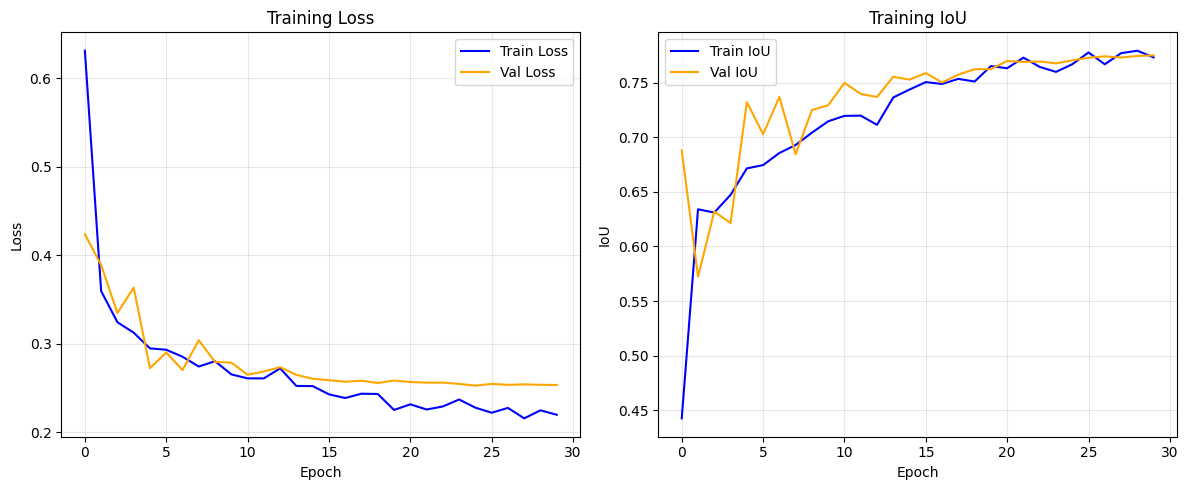

In [26]:
plot_training_curves(
    train_losses=history["train_loss"],
    val_losses=history["val_loss"],
    train_metrics=history["train_iou"],
    val_metrics=history["val_iou"],
    metric_name="IoU",
    save_path=CHECKPOINT_DIR / "seg_training_curves.png",
    show=True,
)

## 12. Инференс скользящим окном

In [15]:
def sliding_window_inference(
    model: nn.Module,
    image: np.ndarray,
    tile_size: int = 512,
    overlap: float = 0.5,
    device: torch.device | str = "cuda",
    use_amp: bool = True,
    batch_size: int = 16,  # RTX 3090: увеличен с 4 до 16
    show_progress: bool = False,
) -> np.ndarray:
    """
    Perform sliding window inference on a large image.
    
    Args:
        model: Trained segmentation model.
        image: Input image (H, W, 3) in uint8 [0, 255] or float32 [0, 1].
        tile_size: Size of inference tiles.
        overlap: Overlap ratio between tiles.
        device: Device to run inference on.
        use_amp: Whether to use mixed precision.
        batch_size: Number of tiles to process in parallel.
        show_progress: Whether to show progress bar.
    
    Returns:
        Predicted mask (H, W) with values in [0, 1].
    """
    if isinstance(device, str):
        device = torch.device(device)
    
    # Проверка входных данных
    if image.ndim != 3 or image.shape[2] != 3:
        raise ValueError(f"Expected image shape (H, W, 3), got {image.shape}")
    
    model.eval()
    h, w = image.shape[:2]
    stride = int(tile_size * (1 - overlap))
    
    # Убеждаемся что stride > 0
    stride = max(stride, 1)
    
    # Вычисляем padding чтобы изображение полностью покрывалось тайлами
    # Нужно: h_pad >= tile_size и (h_pad - tile_size) кратно stride
    if h < tile_size:
        pad_h = tile_size - h
    else:
        remainder = (h - tile_size) % stride
        pad_h = (stride - remainder) % stride
    
    if w < tile_size:
        pad_w = tile_size - w
    else:
        remainder = (w - tile_size) % stride
        pad_w = (stride - remainder) % stride
    
    # Normalize image (используем константы из transforms.py)
    # Поддержка как uint8 [0, 255], так и float32 [0, 1]
    mean = np.array(IMAGENET_MEAN)
    std = np.array(IMAGENET_STD)
    if image.dtype == np.uint8:
        image_norm = (image.astype(np.float32) / 255.0 - mean) / std
    else:
        # Уже float — проверяем диапазон и нормализуем
        image_float = image.astype(np.float32)
        if image_float.max() > 1.0:
            image_float = image_float / 255.0
        image_norm = (image_float - mean) / std
    
    # Pad image с reflect mode для лучших результатов на краях
    if pad_h > 0 or pad_w > 0:
        image_norm = np.pad(
            image_norm,
            ((0, pad_h), (0, pad_w), (0, 0)),
            mode="reflect"
        )
    
    h_pad, w_pad = image_norm.shape[:2]
    
    # Output accumulator and count
    output = np.zeros((h_pad, w_pad), dtype=np.float32)
    count = np.zeros((h_pad, w_pad), dtype=np.float32)
    
    # Sliding window с покрытием всего изображения
    # range гарантирует покрытие от 0 до h_pad - tile_size включительно
    y_positions = list(range(0, h_pad - tile_size + 1, stride))
    x_positions = list(range(0, w_pad - tile_size + 1, stride))
    
    # Если список пустой (изображение == tile_size), добавляем 0
    if not y_positions:
        y_positions = [0]
    if not x_positions:
        x_positions = [0]
    
    # Собираем все позиции тайлов для батчевой обработки
    tile_positions = [(y, x) for y in y_positions for x in x_positions]
    
    # Итератор с опциональным progress bar
    batch_iterator = range(0, len(tile_positions), batch_size)
    num_batches = math.ceil(len(tile_positions) / batch_size)
    if show_progress:
        batch_iterator = tqdm(
            batch_iterator, 
            desc="  Inference", 
            total=num_batches,
            leave=False,
        )
    
    # Обработка тайлов батчами для ускорения
    with torch.inference_mode():
        for batch_start in batch_iterator:
            batch_positions = tile_positions[batch_start:batch_start + batch_size]
            
            # Извлекаем тайлы для текущего батча
            tiles = []
            for y, x in batch_positions:
                tile = image_norm[y:y+tile_size, x:x+tile_size]
                tiles.append(tile.transpose(2, 0, 1))
            
            # Создаём батч тензоров
            batch_tensor = torch.from_numpy(np.stack(tiles, axis=0)).float().to(device)
            
            # Inference с mixed precision
            with autocast(device_type=device.type, dtype=torch.float16, enabled=use_amp):
                preds = model(batch_tensor)
            preds = torch.sigmoid(preds.float()).squeeze(1).cpu().numpy()
            
            # Если батч из одного элемента, preds может быть 2D
            if preds.ndim == 2:
                preds = preds[np.newaxis, ...]
            
            # Накапливаем результаты
            for i, (y, x) in enumerate(batch_positions):
                output[y:y+tile_size, x:x+tile_size] += preds[i]
                count[y:y+tile_size, x:x+tile_size] += 1
    
    # Average overlapping regions
    count = np.maximum(count, 1)
    output = output / count
    
    # Убираем padding
    return output[:h, :w]

## 13. Визуализация предсказаний

In [16]:
# Очистка GPU памяти перед inference
if DEVICE.type == "cuda":
    torch.cuda.empty_cache()

# Load best model for inference
# Checkpoint был сохранён с unwrapped state_dict (без _orig_mod. префикса),
# поэтому load_checkpoint корректно загрузит веса даже в скомпилированную модель
checkpoint_path = CHECKPOINT_DIR / "seg_best_model.pth"
if checkpoint_path.exists():
    state = load_checkpoint(checkpoint_path, model, device=DEVICE)
    print(f"Loaded best model from epoch {state['epoch']} (IoU: {state['best_metric']:.4f})")
else:
    print("Using current model (no checkpoint found)")

2026-01-27 21:27:35,706 - INFO - Model weights loaded from /home/user/code/dls_project/checkpoints/segmentation/seg_best_model.pth


Loaded best model from epoch 30 (IoU: 0.7749)


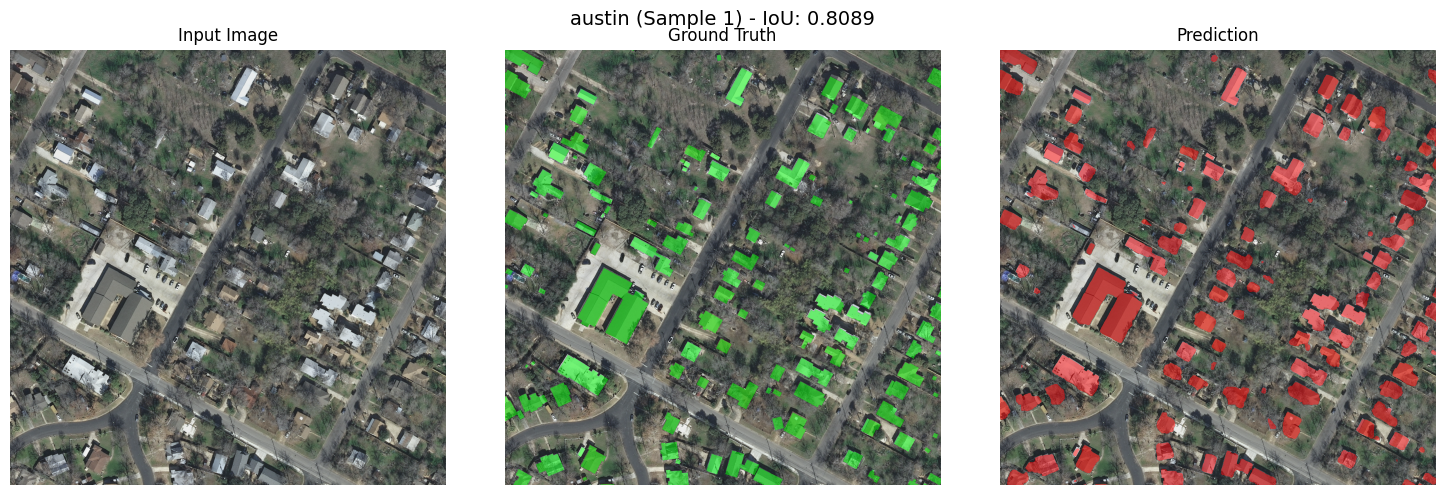

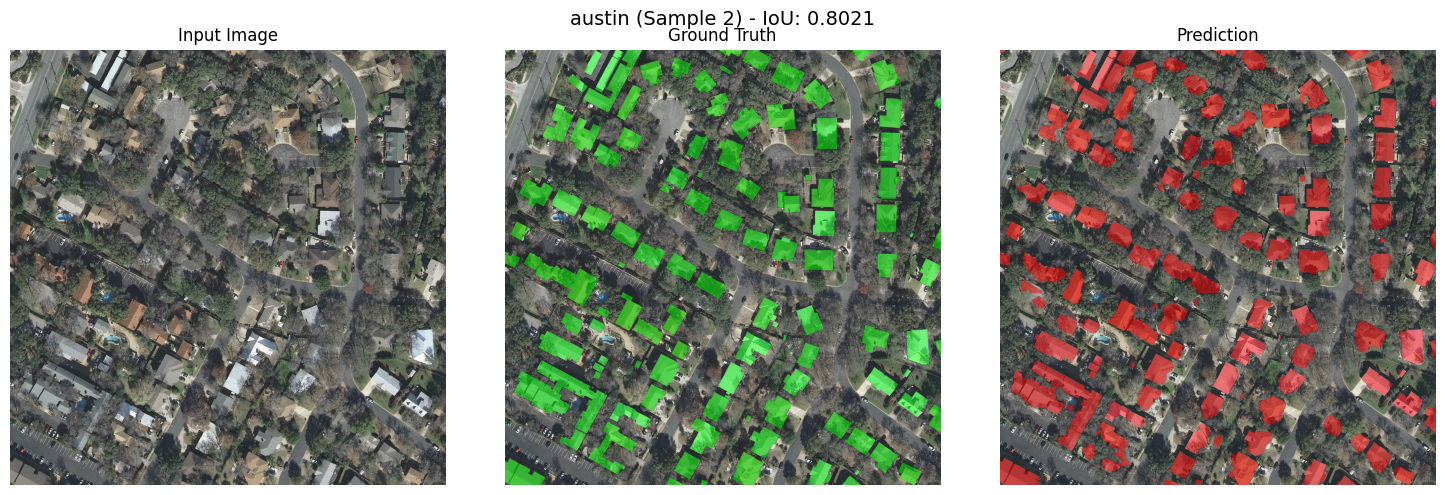

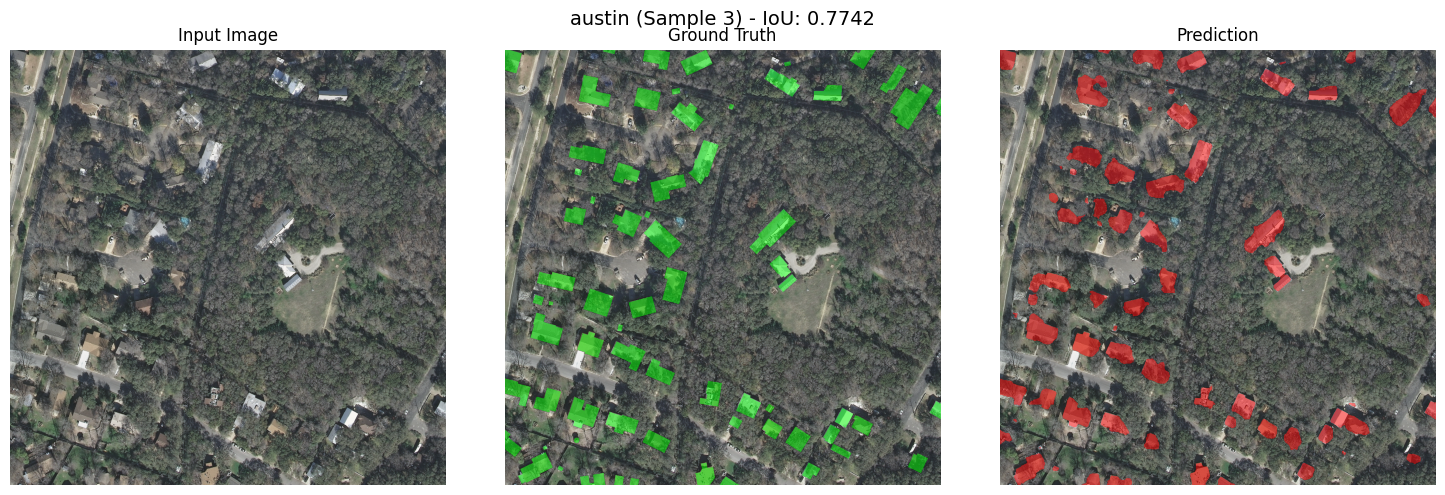

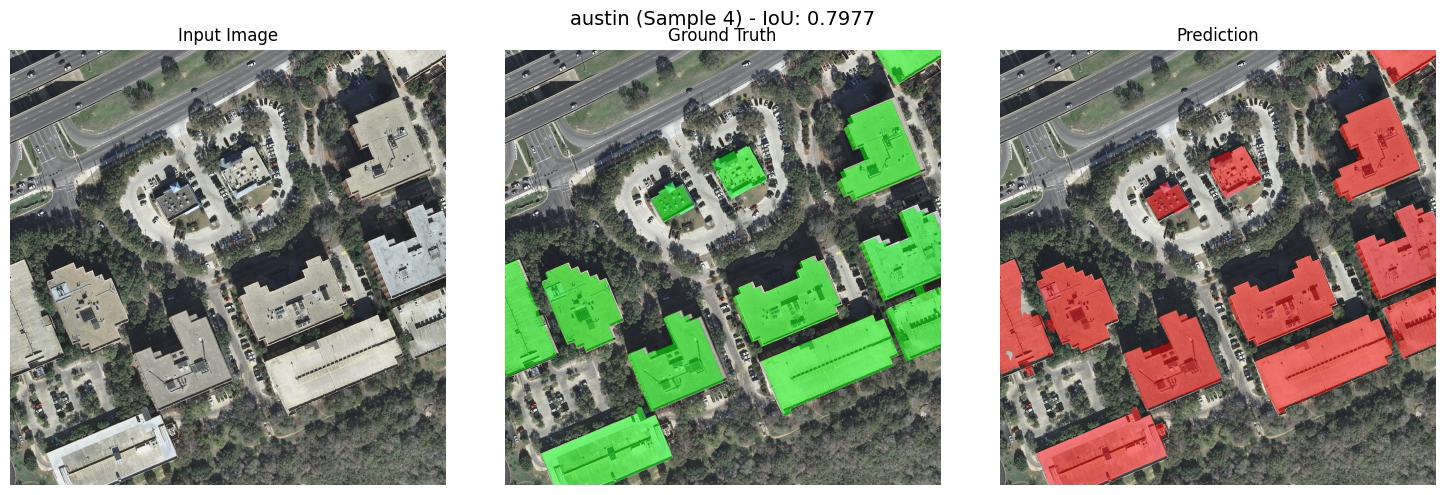

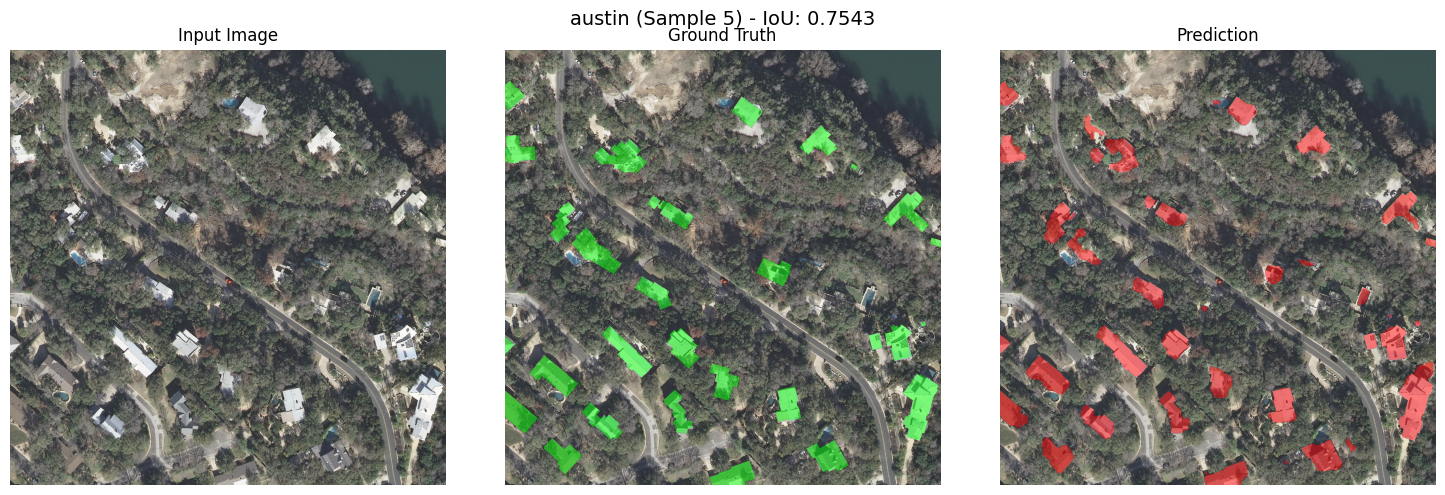

In [17]:
# Visualize predictions on validation samples
model.eval()
num_samples = 5

if val_dataset.num_images == 0:
    print("Warning: Validation dataset is empty, skipping visualization")
else:
    for i in range(min(num_samples, val_dataset.num_images)):
        # Get full resolution image and mask
        image, mask_gt = val_dataset.get_full_image(i)
        city_name = val_dataset.get_city_name(i)
        
        # Run sliding window inference
        mask_pred = sliding_window_inference(
            model, image, tile_size=TILE_SIZE, overlap=0.5, device=DEVICE, 
            use_amp=USE_AMP, batch_size=INFERENCE_BATCH_SIZE
        )
        
        # Calculate metrics for this image
        iou = calculate_iou(mask_pred, mask_gt)
        
        # Visualize (center crop for display)
        crop_size = 1000
        cy, cx = image.shape[0] // 2, image.shape[1] // 2
        s = crop_size // 2
        
        visualize_segmentation(
            image=image[cy-s:cy+s, cx-s:cx+s],
            mask_gt=mask_gt[cy-s:cy+s, cx-s:cx+s],
            mask_pred=mask_pred[cy-s:cy+s, cx-s:cx+s],
            title=f"{city_name} (Sample {i+1}) - IoU: {iou:.4f}",
        )

## 14. Расчёт площади зданий

In [18]:
# Calculate building area for validation images
# GSD определён в конфигурации (секция 1)

area_results = []

if val_dataset.num_images == 0:
    print("Warning: Validation dataset is empty, skipping area calculation")
else:
    print("Calculating building areas...")
    for i in tqdm(range(val_dataset.num_images)):
        image, mask_gt = val_dataset.get_full_image(i)
        
        # Получаем название города через метод датасета
        city_name = val_dataset.get_city_name(i)
        
        # Predict
        mask_pred = sliding_window_inference(
            model, image, tile_size=TILE_SIZE, overlap=0.5, device=DEVICE, 
            use_amp=USE_AMP, batch_size=INFERENCE_BATCH_SIZE
        )
        mask_pred_binary = (mask_pred > 0.5).astype(np.uint8)
        
        # Calculate areas
        area_gt = calculate_area_m2(mask_gt, gsd=GSD)
        area_pred = calculate_area_m2(mask_pred_binary, gsd=GSD)
        
        # IoU
        iou = calculate_iou(mask_pred_binary, mask_gt)
        
        area_results.append({
            "image_idx": i,
            "city": city_name,
            "area_gt_m2": area_gt,
            "area_pred_m2": area_pred,
            "error_m2": abs(area_pred - area_gt),
            "error_pct": abs(area_pred - area_gt) / max(area_gt, 1) * 100,
            "iou": iou,
        })

# Summary statistics
df_results = pd.DataFrame(area_results)

if len(df_results) > 0:
    print("\n" + "=" * 60)
    print("AREA ESTIMATION RESULTS")
    print("=" * 60)
    print(f"Mean Absolute Error: {df_results['error_m2'].mean():,.0f} m2")
    print(f"Mean Absolute Percentage Error (MAPE): {df_results['error_pct'].mean():.2f}%")
    print(f"Mean IoU: {df_results['iou'].mean():.4f}")
    print(f"\nTotal GT Area: {df_results['area_gt_m2'].sum():,.0f} m2")
    print(f"Total Predicted Area: {df_results['area_pred_m2'].sum():,.0f} m2")

df_results

Calculating building areas...


100%|██████████| 25/25 [01:25<00:00,  3.42s/it]


AREA ESTIMATION RESULTS
Mean Absolute Error: 12,401 m2
Mean Absolute Percentage Error (MAPE): 6.13%
Mean IoU: 0.7371

Total GT Area: 7,758,028 m2
Total Predicted Area: 7,892,632 m2


image_idx     city  area_gt_m2  area_pred_m2  error_m2  error_pct  \
0           0   austin   331988.22     333999.27   2011.05   0.605759   
1           1   austin   380137.50     375676.11   4461.39   1.173625   
2           2   austin   353028.15     340275.06  12753.09   3.612485   
3           3   austin   241164.45     239179.86   1984.59   0.822920   
4           4   austin   194489.64     192737.16   1752.48   0.901066   
5           5  chicago   323183.70     368599.50  45415.80  14.052627   
6           6  chicago   698763.96     752157.54  53393.58   7.641147   
7           7  chicago   470008.44     505753.56  35745.12   7.605208   
8           8  chicago   416943.81     444051.09  27107.28   6.501423   
9           9  chicago   370328.76     377578.35   7249.59   1.957609   
10         10   kitsap     4457.16       4069.98    387.18   8.686697   
11         11   kitsap    20145.78      21092.85    947.07   4.701084   
12         12   kitsap   130774.59     133801.47   3026.88   2.314578   
13         13   kitsap    40321.26      18489.78  21831.48  54.143844   
14         14   kitsap    30016.71      23647.95   6368.76  21.217382   
15         15  tyrol-w   157002.03     155128.77   1873.26   1.193144   
16         16  tyrol-w    95456.97      95694.03    237.06   0.248342   
17         17  tyrol-w   233720.28     239042.16   5321.88   2.277030   
18         18  tyrol-w   171427.95     167496.39   3931.56   2.293418   
19         19  tyrol-w   157719.87     156516.03   1203.84   0.763277   
20         20   vienna   405975.42     407154.06   1178.64   0.290323   
21         21   vienna   612670.68     618187.95   5517.27   0.900528   
22         22   vienna   829951.02     798783.03  31167.99   3.755401   
23         23   vienna   644251.41     678017.70  33766.29   5.241167   
24         24   vienna   444100.14     445502.25   1402.11   0.315719   

         iou  
0   0.808875  
1   0.802089  
2   0.774171  
3   0.797693  
4   0.754334  
5   0.720287  
6   0.687448  
7   0.661401  
8   0.690929  
9   0.727598  
10  0.652009  
11  0.795412  
12  0.838422  
13  0.324861  
14  0.458467  
15  0.758497  
16  0.771845  
17  0.780407  
18  0.788178  
19  0.875660  
20  0.772127  
21  0.824706  
22  0.777314  
23  0.815286  
24  0.770522

## 15. Метрики по городам

In [19]:
# Используем результаты из предыдущей ячейки (city уже добавлен)
df_results = pd.DataFrame(area_results)

if len(df_results) == 0:
    print("No results to display - dataset was empty")
else:
    # Group by city
    city_metrics = df_results.groupby("city").agg({
        "iou": "mean",
        "error_pct": "mean",
        "image_idx": "count",
    }).rename(columns={"image_idx": "num_images"})

    print("\n" + "=" * 60)
    print("PER-CITY METRICS")
    print("=" * 60)
    print(f"{'City':<12} {'IoU':<10} {'MAPE %':<10} {'Images':<8}")
    print("-" * 40)
    for city in city_metrics.index:
        row = city_metrics.loc[city]
        print(f"{city:<12} {row['iou']:.4f}    {row['error_pct']:.2f}%     {int(row['num_images'])}")

# Сохранение результатов в JSON
evaluation_results = {
    "model": "UNet-ResNet50",
    "loss": f"BCE({BCE_WEIGHT}) + Dice({DICE_WEIGHT})",
    "best_epoch": best_epoch,
    "best_val_iou": float(best_iou),
    "gsd_m_per_pixel": GSD,
    "metrics": {
        "mean_iou": float(df_results["iou"].mean()),
        "mean_absolute_error_m2": float(df_results["error_m2"].mean()),
        "mape_percent": float(df_results["error_pct"].mean()),
        "total_gt_area_m2": float(df_results["area_gt_m2"].sum()),
        "total_pred_area_m2": float(df_results["area_pred_m2"].sum()),
    },
    "per_city": city_metrics.to_dict(orient="index"),
}

results_path = CHECKPOINT_DIR / "seg_evaluation_results.json"
with open(results_path, "w") as f:
    json.dump(evaluation_results, f, indent=2)
print(f"\nEvaluation results saved to {results_path}")


PER-CITY METRICS
City         IoU        MAPE %     Images  
----------------------------------------
austin       0.7874    1.42%     5
chicago      0.6975    7.55%     5
kitsap       0.6138    18.21%     5
tyrol-w      0.7949    1.36%     5
vienna       0.7920    2.10%     5

Evaluation results saved to /home/user/code/dls_project/checkpoints/segmentation/seg_evaluation_results.json


## Выводы

### Итоги
- **Модель**: UNet с энкодером ResNet-50 (предобученным на ImageNet)
- **Функция потерь**: BCE + Dice Loss (α=0.5, β=0.5)
- **Обучение**: Mixed precision (AMP), OneCycleLR планировщик, оптимизатор AdamW
- **Данные**: Inria Aerial Image Labeling Dataset (5000×5000 px, GSD 0.3 м/пиксель)

### Ключевые наблюдения
1. **Комбинированная функция потерь (BCE + Dice)** помогает балансировать попиксельную точность и пересечение регионов, что критично для сегментации зданий при дисбалансе классов
2. **Skip-соединения** в UNet сохраняют пространственные детали для точного определения границ зданий
3. **Инференс скользящим окном** с 50% перекрытием уменьшает артефакты на краях больших изображений
4. **Mixed precision обучение** значительно ускоряет обучение на GPU без потери качества

### Результаты
- Модель предсказывает маски зданий, которые можно конвертировать в **площадь в м²**, используя GSD
- Результаты сохранены в `checkpoints/segmentation/seg_evaluation_results.json`